In [47]:
import matplotlib.pylab as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import copy

In [555]:
possible_actions = list(itertools.product(np.arange(-2,3), np.arange(-2,3)))
possible_actions = 0.5*np.array(possible_actions)
possible_actions

array([[-1. , -1. ],
       [-1. , -0.5],
       [-1. ,  0. ],
       [-1. ,  0.5],
       [-1. ,  1. ],
       [-0.5, -1. ],
       [-0.5, -0.5],
       [-0.5,  0. ],
       [-0.5,  0.5],
       [-0.5,  1. ],
       [ 0. , -1. ],
       [ 0. , -0.5],
       [ 0. ,  0. ],
       [ 0. ,  0.5],
       [ 0. ,  1. ],
       [ 0.5, -1. ],
       [ 0.5, -0.5],
       [ 0.5,  0. ],
       [ 0.5,  0.5],
       [ 0.5,  1. ],
       [ 1. , -1. ],
       [ 1. , -0.5],
       [ 1. ,  0. ],
       [ 1. ,  0.5],
       [ 1. ,  1. ]])

### Define the simulator

In [781]:
class BrainSim(object):
    C_task = 10
    #state_names = ("MTL", "Frontal")
    gamma_v = 2
    gamma_e = 3
    beta = 0.11
    alpha_1 = 0.1
    alpha_2 = 0.05
    Y_v_max = 5
    
    X_E = np.array([[0,3],[3,0]]) # adjacency matrix
    H = np.diag(np.sum(X_E, axis=1)) - X_E
    
    # deterioration associated with metabolism and pathology

    def get_new_structure(self, D_old, Y_V, X_V):
        # evolution of amyloid deposition over time
        # dD/dt = -beta*H*D
        D_new = D_old - self.beta * self.H @ D_old

        # new health of brain regions
        delta_X = -self.alpha_1*D_new - self.alpha_2*Y_V
        X_V_new = X_V + delta_X

        return X_V_new, D_new

    def calc_node_energy(self, Iv, Xv):
        """compute node energy"""
        return self.gamma_v*Iv/Xv
    
    def __init__(self, num_nodes=2):
        self.C_task = 10
        self.num_actions = len(possible_actions)
        self.state_limits = np.array([[0,10],[0,5]])
        self.reward_bound = 1000
        self.reset('healthy',True)
        
    def reset(self, state_type, randomize=False):
        """Reset the environment."""
        self.t = 0
        if state_type == 'healthy':
            X_V_mean = np.array([4, 3.5]) # MTL, frontal    
            X_V_cov = [[0.25, 0.045], [0.045, 0.01]]  
            D_mean, D_var = 0.03, 0.03 # amyloid deposition
            Y_V = np.array([10.0, 0.0]) # initial load distribution
            
        elif state_type == 'unhealthy':
            X_V = np.array([3.5, 2.1]) # MTL, frontal    
            D = np.array([0.01, 0]) # amyloid deposition
            Y_V = np.array([10.0, 0.0]) # initial load distribution
        
        if randomize:
            self.X_V = np.random.multivariate_normal(X_V_mean, X_V_cov)
            self.D = np.array([abs(np.random.normal(D_mean, D_var, 1))[0], 0])
        
        self.state = Y_V 
        return self.state
    
    def observe(self):
        return self.state
    
    def is_done(self, episode_length=10):
        ##Check if the episode is complete
        return True if self.t >= episode_length else False
 
    def calc_reward(self, state, X_V):    
        M = self.calc_node_energy(state,X_V)
        Ct = np.sum(state)
        
        #power_factor = np.clip(-self.C_task + Ct,a_min=0,a_max=None)
        #factor = 10**power_factor
        
        reward = -(np.abs(self.C_task - Ct)*10 + np.sum(M))
        
        
        # Constrain reward to be within specified range
        if np.isnan(reward):
            reward = -self.reward_bound
        elif reward > self.reward_bound:
            reward = self.reward_bound
        elif reward < -self.reward_bound:
            reward = -self.reward_bound
        return reward
 
    def step(self, action):
        self.t += 1
        #update loads
        self.state = self.state + possible_actions[action]
        
        self.state = np.clip(self.state, a_min=self.state_limits[:,0], a_max=self.state_limits[:,1])
        
        Y_V = self.calc_node_energy(self.state, self.X_V)
        self.X_V, self.D = self.get_new_structure(self.D, Y_V, self.X_V)
        self.X_V = np.clip(self.X_V,a_min=0.0001, a_max=None)
        
#         r = ode(self.model_derivatives).set_integrator('vode',nsteps=10000,method='bdf')
#         t0 = 0
#         deriv_args = (eps1, eps2)
#         r.set_initial_value(self.state, t0).set_f_params(deriv_args)
#         self.state = r.integrate(self.dt)
        reward = self.calc_reward(self.state, self.X_V)
        done = self.is_done()
        return self.state, reward, done

In [782]:
env = BrainSim()
reward= 0

actions = [12,8,8,4,8,8,8,4,8] #close to Saboo's policy
#actions = [2, 2, 2, 3, 3, 2, 2, 3, 3] #optimal policy
actions = [4,4,4,4,4,4,4,4,4]
actions = action_saboo
for i in range(9):
    action = actions[i] #np.random.randint(len(possible_actions))
#     new_state = (possible_actions[action] + env.state)
#     while (np.sum(new_state)>10) or new_state[0]<0 or new_state[1]<0:
#         action = np.random.randint(len(possible_actions))
#         new_state = (possible_actions[action] + env.state)
    
    result = env.step(action)
    
    reward += result[1]
    print(f"Action:{possible_actions[action]},State:{result[0]},Reward:{result[1]}")

    #print("Condition(X_V)",env.X_V)
print("Total Reward",reward)

Action:[0. 0.],State:[10.  0.],Reward:-5.48586556316985
Action:[-0.5  0.5],State:[9.5 0.5],Reward:-5.899011088862663
Action:[-0.5  0.5],State:[9. 1.],Reward:-6.348457205050175
Action:[-1.  1.],State:[8. 2.],Reward:-6.76227648790571
Action:[-0.5  0.5],State:[7.5 2.5],Reward:-7.268886384642377
Action:[-0.5  0.5],State:[7. 3.],Reward:-7.8598049621643415
Action:[-1.  1.],State:[6. 4.],Reward:-8.356087020711266
Action:[-0.5  0.5],State:[5.5 4.5],Reward:-9.12090697629959
Action:[-0.5  0.5],State:[5. 5.],Reward:-10.12019331251062
Total Reward -67.22148900131658


In [848]:
class PolicyGradient(nn.Module):
    def __init__(self, outputs):
        super(PolicyGradient, self).__init__()
        self.network = nn.Sequential(
        nn.BatchNorm1d(num_features=2, affine=False),
        nn.Linear(2,10),
        nn.ReLU(),
        nn.Linear(10, outputs))

    def forward(self, x):
        x=x.double()
        x = self.network(x)
        return x

def sample_episode(env, policy, max_episode_length,epsilon):
    ob = env.reset('healthy',True)
    #print(env.X_V, env.D)
    obs, acs, log_p, rewards, next_obs, terminals = [], [], [], [], [], []
    steps = 0
    while True:
         # use the most recent observation
        obs.append(ob)
        ac = sample_action(policy, ob, epsilon)
        acs.append(ac)
        # take that action and record results
        ob, rew, done = env.step(ac)
        # record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
             rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break
    return obs, acs, rewards, next_obs, terminals

def sample_action(policy_net, obs, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(len(possible_actions))
    obs = torch.tensor(obs.reshape(1, -1), dtype=torch.float64)
    return (
     torch.distributions.Categorical(logits=policy_net.eval().double().forward(obs))
     .sample()
     .item()
     )
def sample_batch_episodes(env, policy, episodes_per_batch, max_episode_length,epsilon):
    episode_count = 0
    episodes = []
    for i in range(episodes_per_batch):
        episode = sample_episode(env, policy, max_episode_length,epsilon)
        episodes.append(episode)
    return episodes

def log_prob(policy_net,obs, action):
    log_probs = nn.functional.log_softmax(policy_net.forward(obs), dim=1)[:,]
    action_one_hot = nn.functional.one_hot(action, num_classes=len(possible_actions))
    return torch.sum(log_probs * action_one_hot, dim=1)

def reward_discounted(gamma,rewards):
    all_discounted_cumsums = []
    # for loop over steps (t) of the given rollout
    for start_time_index in range(len(rewards)):
        indices = np.arange(start_time_index, len(rewards))
        discounts = gamma ** (indices - start_time_index)
        all_discounted_cumsums.append(sum(discounts * rewards[start_time_index:]))
    return np.array(all_discounted_cumsums)

In [ ]:
n_iter = 2000
batch_size = 200
max_episode_length = 11
epsilon = 1.0
GAMMA = 0.999
learning_rate = 1e-3
policy_net = PolicyGradient(len(possible_actions)).double()
avg_rewards = np.zeros(n_iter)
avg_episode_lengths = np.zeros(n_iter)
env = BrainSim()
log_loss = np.zeros(n_iter)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
policy_net.train()
best_reward = -float('Inf')
best_policy_new = copy.deepcopy(policy_net)

for itr in range(n_iter):
    if itr % 10 == 0:
        print(f"*****Iteration {itr}*****")
        print(f"Loss:{loss.item()},Reward:{avg_reward}")
    if avg_reward > best_reward and itr > 800:
        best_policy_new = copy.deepcopy(policy_net)
        #episode = sample_episode(env, best_policy_new, max_time, 0)
        #print(episode)
    episodes = sample_batch_episodes(env, policy_net, batch_size, max_episode_length,epsilon)
    total_reward = 0
    obs = np.concatenate([tau[0] for tau in episodes], axis=0).astype(np.float64)
    acs = np.concatenate([tau[1] for tau in episodes], axis=0).astype(np.int64)
    obs = torch.from_numpy(obs)
    acs = torch.from_numpy(acs)

    disc_rewards = []
    for e in episodes:
        total_reward += np.sum(e[2])

    disc_rewards = np.concatenate([reward_discounted(GAMMA,tau[2]) for tau in episodes], axis=0).astype(np.float32)
    log_ps = log_prob(policy_net,obs,acs)
    
    avg_reward = total_reward/batch_size

    advantage = (disc_rewards - disc_rewards.mean())/disc_rewards.std() + 1e-8 #np.standardize(disc_rewar
    loss = -torch.mean(log_ps * torch.tensor(advantage, dtype=torch.float64))
    
    avg_rewards[itr] = avg_reward
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    log_loss[itr] = loss.item()
    # Update rule for epsilon s.t. after 100 iterations it's around 0.01.
    epsilon = np.maximum(0.01,epsilon*0.97)

*****Iteration 0*****
Loss:-0.054417047979076504,Reward:-1236.3257448900217
*****Iteration 10*****
Loss:-0.0756269841367901,Reward:-1269.7867811503272
*****Iteration 20*****
Loss:-0.10321453003982022,Reward:-1211.1346831920825
*****Iteration 30*****
Loss:-0.08127631884778258,Reward:-1492.2193217399692
*****Iteration 40*****
Loss:-0.005516410463754166,Reward:-998.2563701272104
*****Iteration 50*****
Loss:-0.06421858802365973,Reward:-897.0102167759856
*****Iteration 60*****
Loss:-0.033510278710976324,Reward:-1076.066638014246
*****Iteration 70*****
Loss:-0.015939089392121936,Reward:-766.264816616086
*****Iteration 80*****
Loss:0.002623590994821079,Reward:-745.8838708220869
*****Iteration 90*****
Loss:0.03395295462784745,Reward:-571.5938170639348
*****Iteration 100*****
Loss:0.0549756016263761,Reward:-546.6980841100537
*****Iteration 110*****
Loss:0.07370334751114097,Reward:-605.9830237511112
*****Iteration 120*****
Loss:0.06629224345481392,Reward:-601.4264762527915
*****Iteration 130****

*****Iteration 1090*****
Loss:0.06499696077183274,Reward:-210.042828469279
*****Iteration 1100*****
Loss:0.0472824532593267,Reward:-240.03347772611653
*****Iteration 1110*****
Loss:0.06199057123623612,Reward:-248.00940007865006
*****Iteration 1120*****
Loss:0.045440923327019746,Reward:-206.87805014910248
*****Iteration 1130*****
Loss:0.020488100072610017,Reward:-245.04559336475785
*****Iteration 1140*****
Loss:0.06030654840694615,Reward:-157.63970073355074
*****Iteration 1150*****
Loss:-0.06975873487245707,Reward:-186.69749518925312
*****Iteration 1160*****
Loss:0.03097406714016802,Reward:-246.98496677727965
*****Iteration 1170*****
Loss:-0.05495534209236767,Reward:-192.1975248359299
*****Iteration 1180*****
Loss:0.033458222111681285,Reward:-210.98735293126575
*****Iteration 1190*****
Loss:0.014998600506105056,Reward:-269.7877580799929
*****Iteration 1200*****
Loss:0.0011540807572548886,Reward:-209.48625232328442
*****Iteration 1210*****
Loss:-0.007929485131332353,Reward:-188.763098946

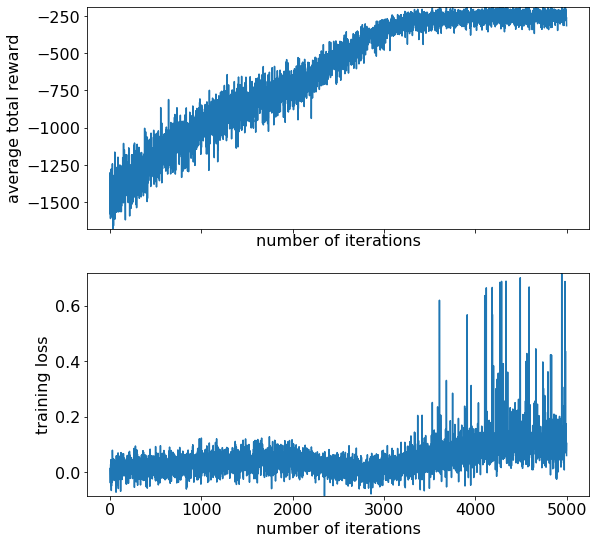

In [851]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[9, 9])
ax1.plot(avg_rewards)
ax1.set_xlabel("number of iterations")
ax1.set_ylabel("average total reward")
ax1.set_ylim(avg_rewards.min(), avg_rewards.max())
ax2.plot(log_loss)
ax2.set_xlabel("number of iterations")
ax2.set_ylabel("training loss")
ax2.set_ylim(log_loss.min(), log_loss.max())
plt.show()

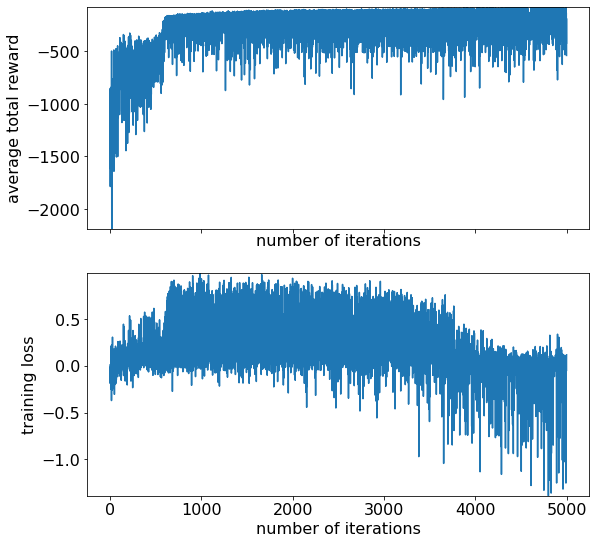

In [812]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[9, 9])
ax1.plot(avg_rewards)
ax1.set_xlabel("number of iterations")
ax1.set_ylabel("average total reward")
ax1.set_ylim(avg_rewards.min(), avg_rewards.max())
ax2.plot(log_loss)
ax2.set_xlabel("number of iterations")
ax2.set_ylabel("training loss")
ax2.set_ylim(log_loss.min(), log_loss.max())
plt.show()

In [853]:
def sample_episode_final(env, policy, max_episode_length,epsilon):
    ob = env.reset('healthy',True)
    orig_X_V,orig_D = env.X_V, env.D
    obs, acs, log_p, rewards, next_obs, terminals = [], [], [], [], [], []
    steps = 0
    while True:
         # use the most recent observation
        obs.append(ob)
        ac = sample_action(policy, ob, epsilon)
        acs.append(ac)
        # take that action and record results
        ob, rew, done = env.step(ac)
        # record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
             rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break
    return obs, acs, rewards, next_obs, terminals, orig_X_V, orig_D

def get_cogn_Y(X_V):
    # if MTL is healthy enough, it will do everything
    erg1 = gamma_v*C_task/X_V[0]

    if erg1 <= Y_v_max:
        Y_V = np.array([erg1, 0])
        I_V = np.array([C_task, 0])

    else:
        # MTL is not healthy enough so workload is divided
        I_1 = Y_v_max*X_V[0]/gamma_v

        # remaining is processed by frontal areas
        erg2 = gamma_v*(C_task-I_1)/X_V[1]

        if erg2 <= Y_v_max:
            Y_V = np.array([Y_v_max, erg2])
            I_V = np.array([I_1, C_task-I_1])
        else:
            # frontal region is not strong enough
            I_2 = Y_v_max*X_V[1]/gamma_v

            Y_V = np.array([Y_v_max, Y_v_max])
            I_V = np.array([I_1, I_2])

    return Y_V, I_V

# deterioration associated with metabolism and pathology

def get_new_structure(D_old, Y_V):
    # evolution of amyloid deposition over time
    # dD/dt = -beta*H*D
    D_new = D_old - beta * H @ D_old
    
    # new health of brain regions
    delta_X = -alpha_1*D_new -alpha_2*Y_V
    X_V_new = X_V + delta_X
    
    return X_V_new, D_new

loads_rl_new, loads_saboo_new = [], []
rewards_rl_new, rewards_saboo_new = [], []
all_actions_rl_new, all_actions_saboo_new = [], []

X_V_all, D_all = [], []

for iter in range(20):
    max_time = 11
    dt = 1
    env = BrainSim()
    episode = sample_episode_final(env, best_policy_new, max_time, 0)
    #print(episode)
    
    # the way cognitive load is modified
    # NOTE that there is no tract deterioration included in this model

    X_V = episode[-2].copy() # MTL, frontal
    X_E = np.array([[0,3],[3,0]]) # adjacency matrix
    D = np.array(episode[-1].copy())
    
    X_V_all.append(X_V)
    D_all.append(D)

    num_regions = len(X_V)

    #D = np.array([0.01, 0]) # amyloid deposition
    C_task = 10

    gamma_v = 2
    gamma_e = 3
    beta = 0.11
    alpha_1 = 0.1
    alpha_2 = 0.05
    Y_v_max = 5

    H = np.diag(np.sum(X_E, axis=1)) - X_E

    # change in cognition and health over time
    total_time = 10

    infodist_mat = np.zeros((num_regions, total_time+1))
    struct_mat = np.zeros((num_regions, total_time+1))
    func_mat = np.zeros((num_regions, total_time+1))

    for tm in range(total_time+1):
        struct_mat[:,tm] = X_V

        # cognition value
        Y_V, I_V = get_cogn_Y(X_V)
        infodist_mat[:,tm] = I_V
        func_mat[:,tm] = Y_V

        # update health
        X_V, D = get_new_structure(D, Y_V)
    
    rounded = np.round(infodist_mat*2)/2
    #print(rounded)
    diff = rounded[:,1:11]-rounded[:,0:10]
    #print(diff)
    action_saboo = []
    for i in range(10):
        action_saboo.append(np.where((possible_actions[:,0]==diff.T[i][0])&(possible_actions[:,1]==diff.T[i][1]))[0][0])
        
    
    action_rl = episode[1].copy()
    
    env=BrainSim()
    env.X_V = episode[-2].copy()
    env.D = episode[-1].copy()
    actions = action_rl
    loads = []
    rewards = []
    
    for i in range(10):
        action = actions[i] #np.random.randint(len(possible_actions))
        result = env.step(action)
        #reward += result[1]
        loads.append(result[0])
        rewards.append(result[1])
        #print(f"Action:{possible_actions[action]},State:{result[0]},Reward:{result[1]}")
    
    all_actions_rl_new.append(actions)
    loads_rl_new.append(loads)
    rewards_rl_new.append(rewards)
    
    env=BrainSim()
    env.X_V = episode[-2].copy()
    env.D = episode[-1].copy()
    actions = action_saboo
    loads = []
    rewards = []
    
    for i in range(10):
        action = actions[i] #np.random.randint(len(possible_actions))
        result = env.step(action)
        #reward += result[1]
        loads.append(result[0])
        rewards.append(result[1])
        #print(f"Action:{possible_actions[action]},State:{result[0]},Reward:{result[1]}")
    
    all_actions_saboo_new.append(actions)
    loads_saboo_new.append(loads)
    rewards_saboo_new.append(rewards)
    
    
    
    #print("Condition(X_V)",env.X_V,env.D)

In [854]:
print(np.array(rewards_rl).shape)
#print(np.array(loads_saboo))
X_D = [f'{np.round(X_V_all[i],2)} ; {np.round(D_all[i],2)}' for i in range(10)]
print(X_D)
#np.concatenate((X_V_all_round,np.round(D_all,2)),axis=1)

(10, 10)
['[3.65 3.49] ; [0.06 0.  ]', '[3.82 3.44] ; [0.02 0.  ]', '[4.18 3.5 ] ; [0.01 0.  ]', '[3.31 3.4 ] ; [0.01 0.  ]', '[4.82 3.65] ; [0.02 0.  ]', '[4.38 3.59] ; [0.11 0.  ]', '[2.72 3.18] ; [0.01 0.  ]', '[3.9  3.49] ; [0.05 0.  ]', '[4.05 3.55] ; [0.04 0.  ]', '[4.58 3.6 ] ; [0.05 0.  ]']


[[10.  10.  10.  10.  10.   9.5  8.5  7.5  6.5  5.5]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.5  6. ]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.   5. ]
 [10.  10.  10.  10.   9.5  9.5  8.5  7.5  7.   6. ]
 [10.  10.  10.  10.  10.   9.   8.5  8.   7.   5.5]
 [10.  10.   9.5  9.   9.   9.   8.5  7.5  6.   5.5]
 [10.   9.5  9.5  9.5  9.5  9.5  8.5  7.5  7.   7. ]
 [10.  10.  10.  10.  10.   9.   8.   7.   7.   7. ]
 [10.  10.  10.  10.  10.   9.   8.5  7.5  6.   5.5]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.5  6. ]
 [10.  10.  10.  10.  10.   8.5  8.   8.   8.   8. ]
 [10.  10.  10.  10.  10.   9.   8.   7.5  7.5  6.5]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.5  6. ]
 [10.  10.  10.  10.  10.   9.5  8.5  7.5  6.5  5.5]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.5  5.5]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.5  6. ]
 [10.  10.  10.  10.  10.   9.   8.   6.5  5.   6.5]
 [10.  10.  10.  10.  10.   9.   8.   7.   6.   5. ]
 [10.  10.  10.  10.  10.   9.   8.   7.   6. 

(-200, 0)

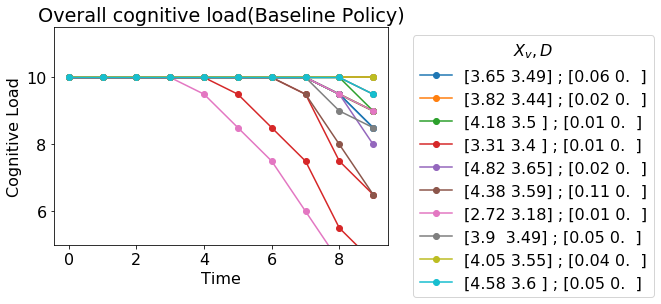

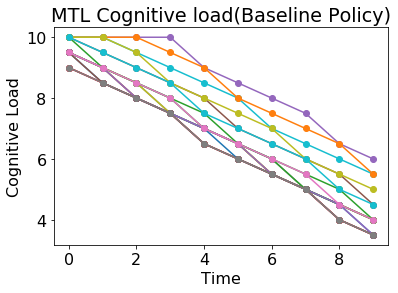

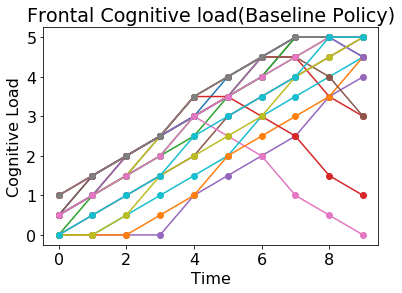

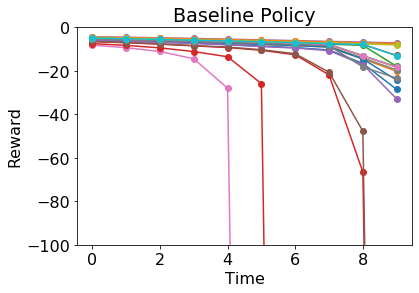

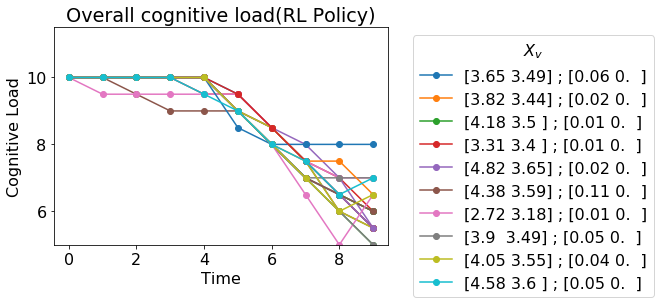

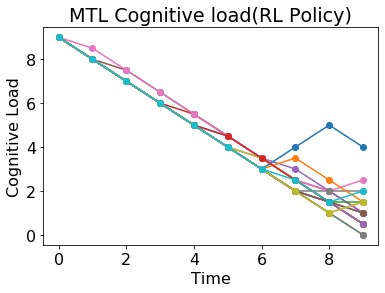

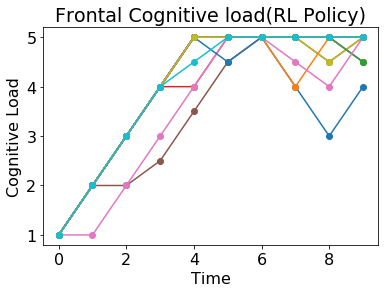

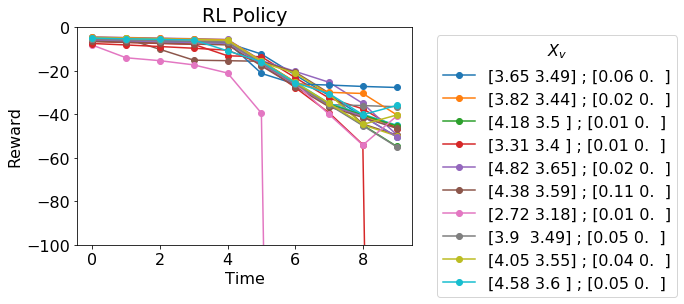

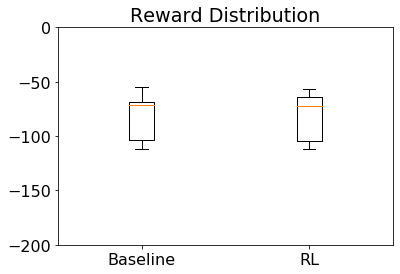

In [855]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

X_V_all_round = np.round(X_V_all,2)
rewards_sum = {'Baseline': np.sum(np.array(rewards_saboo)[:,:],axis=1), 'RL': np.sum(np.array(rewards_rl)[:,:],axis=1)}

loads_saboo_new = np.array(loads_saboo_new)
#print(np.sum(loads_saboo,2))
loads_rl_new = np.array(loads_rl_new)
print(np.sum(loads_rl_new,2))
#print(np.array(loads_saboo).shape) #.reshape(10,-1))

#fig, ax = plt.subplots(figsize=(2,1))
plt.figure()
plt.plot(np.sum(loads_saboo_new,axis=2).T,'-o')
plt.legend(X_D, title="$X_v, D$",bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Cognitive Load")
plt.xlabel("Time")
plt.title("Overall cognitive load(Baseline Policy)")
plt.ylim(5,11.5)

plt.figure()
plt.plot(np.array(loads_saboo_new[:,:,0]).T,'-o')
plt.ylabel("Cognitive Load")
plt.xlabel("Time")
plt.title("MTL Cognitive load(Baseline Policy)")

plt.figure()
plt.plot(np.array(loads_saboo_new[:,:,1]).T,'-o')
plt.ylabel("Cognitive Load")
plt.xlabel("Time")
plt.title("Frontal Cognitive load(Baseline Policy)")

plt.figure()
plt.plot(np.array(rewards_saboo_new)[:,:].T,'-o')
plt.ylabel("Reward")
plt.xlabel("Time")
plt.title("Baseline Policy")
plt.ylim(-100,0)

plt.figure()
plt.plot(np.sum(loads_rl_new,axis=2).T,'-o')
plt.legend(X_D, title="$X_v$",bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Cognitive Load")
plt.xlabel("Time")
plt.title("Overall cognitive load(RL Policy)")
plt.ylim(5,11.5)

plt.figure()
plt.plot(np.array(loads_rl_new[:,:,0]).T,'-o')
plt.ylabel("Cognitive Load")
plt.xlabel("Time")
plt.title("MTL Cognitive load(RL Policy)")

plt.figure()
plt.plot(np.array(loads_rl_new[:,:,1]).T,'-o')
plt.ylabel("Cognitive Load")
plt.xlabel("Time")
plt.title("Frontal Cognitive load(RL Policy)")

plt.figure()
plt.plot(np.array(rewards_rl_new)[:,:].T,'-o')
plt.ylabel("Reward")
plt.xlabel("Time")
plt.title("RL Policy")
plt.legend(X_D, title="$X_v$",bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-100,0)

fig, ax = plt.subplots()
ax.boxplot(rewards_sum.values())
ax.set_xticklabels(rewards_sum.keys())
plt.title("Reward Distribution")
plt.ylim(-200,0)

# plt.boxplot(,1)
# plt.boxplot(rewards_rl_sum,1)

In [655]:
episode

([array([10.,  0.]),
  array([9., 1.]),
  array([8., 2.]),
  array([7., 3.]),
  array([6., 4.]),
  array([5.5, 5. ]),
  array([5.5, 5. ]),
  array([4.5, 5. ]),
  array([3.5, 5. ])],
 [4, 4, 4, 4, 9, 14, 4, 4, 9],
 [-4.978049535460971,
  -5.270264412198976,
  -5.549776143436706,
  -5.832365054896272,
  -11.453535420032741,
  -11.79754064851857,
  -11.510069047961185,
  -21.19415453775689,
  -26.233884619803355],
 [array([9., 1.]),
  array([8., 2.]),
  array([7., 3.]),
  array([6., 4.]),
  array([5.5, 5. ]),
  array([5.5, 5. ]),
  array([4.5, 5. ]),
  array([3.5, 5. ]),
  array([3., 5.])],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 array([4.28974597, 3.59109695]),
 array([0.06353344, 0.        ]))

[[10.         10.          9.5051561   8.87190228  8.23885448  7.60587671
   6.97292277  6.33997691  5.70703382  5.07409165  4.44114981]
 [ 0.          0.          0.4948439   1.12809772  1.76114552  2.39412329
   3.02707723  3.66002309  4.29296618  4.92590835  5.55885019]]
[[10.  10.   9.5  9.   8.   7.5  7.   6.5  5.5  5.   4.5]
 [ 0.   0.   0.5  1.   2.   2.5  3.   3.5  4.5  5.   5.5]]
[[ 0.  -0.5 -0.5 -1.  -0.5 -0.5 -0.5 -1.  -0.5 -0.5]
 [ 0.   0.5  0.5  1.   0.5  0.5  0.5  1.   0.5  0.5]]


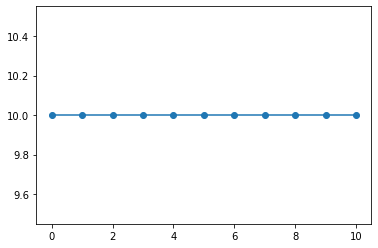

In [657]:
print(infodist_mat)

plt.plot(np.sum(infodist_mat,axis=0),'-o')
plt.show()

In [658]:
action_saboo = []
for i in range(10):
    action_saboo.append(np.where((possible_actions[:,0]==diff.T[i][0])&(possible_actions[:,1]==diff.T[i][1]))[0][0])

In [659]:
action_saboo

[12, 8, 8, 4, 8, 8, 8, 4, 8, 8]

In [661]:
env=BrainSim()
env.X_V = X_V_orig.copy()
env.D = episode[-1].copy()
reward= 0
actions = episode[1].copy()
#actions = action_saboo
for i in range(9):
    action = actions[i] #np.random.randint(len(possible_actions))
#     new_state = (possible_actions[action] + env.state)
#     while (np.sum(new_state)>10) or new_state[0]<0 or new_state[1]<0:
#         action = np.random.randint(len(possible_actions))
#         new_state = (possible_actions[action] + env.state)
    
    result = env.step(action)
    
    reward += result[1]
    print(f"Action:{possible_actions[action]},State:{result[0]},Reward:{result[1]}")

    #print("Condition(X_V)",env.X_V,env.D)
print("Total Reward",reward)

Action:[-1.  1.],State:[9. 1.],Reward:-5.418078771153343
Action:[-1.  1.],State:[8. 2.],Reward:-5.75493796115965
Action:[-1.  1.],State:[7. 3.],Reward:-6.076048814381455
Action:[-1.  1.],State:[6. 4.],Reward:-6.396458291827645
Action:[-0.5  1. ],State:[5.5 5. ],Reward:-12.10207253214262
Action:[0. 1.],State:[5.5 5. ],Reward:-12.566146552089233
Action:[-1.  1.],State:[4.5 5. ],Reward:-12.296369870676298
Action:[-1.  1.],State:[3.5 5. ],Reward:-21.979094286660235
Action:[-0.5  1. ],State:[3. 5.],Reward:-27.089804687419164


IndexError: list index out of range